In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import rioxarray
import numpy as np
import pandas as pd

In [51]:
# attribution temp/perc
att_temp = pd.read_csv("data/grid5_tas_adj_attribution_categories_years.csv")
att_temp = att_temp.loc[att_temp.year==2018]
att_temp["LON_5"] = att_temp.LON_5.apply(lambda x: x-360 if x>180 else x)

att_prec = pd.read_csv("data/grid25_precip_attribution_categories_years.csv")
att_prec = att_prec.loc[att_prec.year==2016]
att_prec["LON_25"] = att_prec.LON_25.apply(lambda x: x-360 if x>180 else x)

In [54]:
# population density
rds = rioxarray.open_rasterio("data/gpw_v4_population_count_rev11_2020_1_deg.asc")
rds = rds.squeeze().drop("spatial_ref").drop("band")
rds.name = "population"
pop_df = rds.to_dataframe().reset_index()
# regridding
print(pop_df.shape)
pop_df['LAT_5'] = pop_df['y']//5*5+2.5
pop_df['LON_5'] = pop_df['x']//5*5+2.5
print(pop_df.shape)
pop_df['LAT_25'] = pop_df['y']//2.5*2.5+1.25
pop_df['LON_25'] = pop_df['x']//2.5*2.5+1.25
pop_df.loc[pop_df['population'].isin([-9999,0]),"population"]=np.NaN
pop_df_5 = pop_df.groupby(["LAT_5","LON_5"])['population'].sum().reset_index()
pop_df_25 = pop_df.groupby(["LAT_25","LON_25"])['population'].sum().reset_index()



att_temp = att_temp.merge(pop_df_5[["LAT_5", "LON_5", "population"]], 
                                on=["LAT_5", "LON_5"],
                                how="left"
                               )
att_prec = att_prec.merge(pop_df_25[["LAT_25", "LON_25", "population"]], 
                                on=["LAT_25", "LON_25"],
                                how="left"
                               )

(64800, 3)
(64800, 5)


In [40]:
country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259200 entries, 0 to 259199
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   lat_05             259200 non-null  float64
 1   lon_05             259200 non-null  float64
 2   LAT                259200 non-null  float64
 3   LON                259200 non-null  float64
 4   LAT_5              259200 non-null  float64
 5   LON_5              259200 non-null  float64
 6   LAT_25             259200 non-null  float64
 7   LON_25             259200 non-null  float64
 8   area               259200 non-null  float64
 9   ISO_A3             61419 non-null   object 
 10  country            61419 non-null   object 
 11  high_income        259200 non-null  bool   
 12  low_middle_income  259200 non-null  bool   
dtypes: bool(2), float64(9), object(2)
memory usage: 22.2+ MB


In [55]:
# load country data
country = pd.read_csv("data/worldbank_grid_high_low_income.csv")

att_temp = att_temp.merge(country[['LAT_5', 'LON_5','area', 'ISO_A3', 'country', 'high_income', 'low_middle_income']],
                          on=['LAT_5', 'LON_5'],
                          how="left"
                         )
att_prec = att_prec.merge(country[['LAT_25', 'LON_25','area', 'ISO_A3', 'country', 'high_income', 'low_middle_income']],
                          on=['LAT_25', 'LON_25'],
                          how="left"
                         )



In [64]:
# calculate
att_prec["human_intervention"] = att_prec.Attribution_Category.apply(lambda x: True if abs(x)>1 and abs(x)<4 else False )
att_temp["human_intervention"] = att_temp.Attribution_Category.apply(lambda x: True if abs(x)>1 and abs(x)<4 else False )

temp_tot = sum(att_temp.population)
temp_low = sum(att_temp.loc[att_temp.low_middle_income,"population"])
temp_high = sum(att_temp.loc[att_temp.high_income,"population"])

temp_hi=sum(att_temp.loc[att_temp.human_intervention, "population"])
temp_hi_low=sum(att_temp.loc[(att_temp.human_intervention) & (att_temp.low_middle_income), "population"])
temp_hi_high=sum(att_temp.loc[(att_temp.human_intervention) & (att_temp.high_income), "population"])

print(" ### TEMPERATURE ### ")
print(f"{round(temp_low/temp_tot*100,2)} of the total population belong to low-middle-income countries")
print(f"{round(temp_hi_low/temp_low*100,2)} of the population living in low-middle income countries are affected by cc attributed to human interventions")

print(f"{round(temp_high/temp_tot*100,2)} of the total population belong to high-income countries")
print(f"{round(temp_hi_high/temp_high*100,2)} of the population living in high income countries are affected by cc attributed to human interventions")


 ### TEMPERATURE ### 
64.86 of the total population belong to low-middle-income countries
75.98 of the population living in low-middle income countries are affected by cc attributed to human interventions
10.82 of the total population belong to high-income countries
84.8 of the population living in high income countries are affected by cc attributed to human interventions


In [60]:
prec_tot = sum(att_prec.population)
prec_low = sum(att_prec.loc[att_prec.low_middle_income,"population"])
prec_high = sum(att_prec.loc[att_prec.high_income,"population"])

prec_hi=sum(att_prec.loc[att_prec.human_intervention, "population"])
prec_hi_low=sum(att_prec.loc[(att_prec.human_intervention) & (att_prec.low_middle_income), "population"])
prec_hi_high=sum(att_prec.loc[(att_prec.human_intervention) & (att_prec.high_income), "population"])

print(" ### PRECIPITATION ### ")
print(f"{round(prec_low/prec_tot*100,2)} of the total population belong to low-middle-income countries")
print(f"{round(prec_hi_low/prec_low*100,2)} of the population living in low-middle income countries are affected by cc attributed to human interventions")

print(f"{round(prec_high/prec_tot*100,2)} of the total population belong to high-income countries")
print(f"{round(prec_hi_high/prec_high*100,2)} of the population living in high income countries are affected by cc attributed to human interventions")


70.76 of the total population belong to low-middle-income countries
2.19 of the population living in low-middle income countries are affected by cc attributed to human interventions
11.76 of the total population belong to high-income countries
4.88 of the population living in high income countries are affected by cc attributed to human interventions


In [62]:


import numpy as np
def generate_grid_df(degrees):
    '''
    Generate a dataframe with a grid of of cells degrees x degrees
    '''
    LON = np.linspace(-180+degrees*0.5,180-degrees*0.5,int(360/degrees))
    LAT = np.linspace(-90+degrees*0.5,90-degrees*0.5,int(180/degrees))
    lon_df, lat_df = np.meshgrid(LON,LAT)

    return pd.DataFrame({"LAT": lat_df.ravel(), "LON": lon_df.ravel()})
    
grid_df = generate_grid_df(2.5)
grid_df.head()



,LAT,LON
0,-88.75,-178.75
1,-88.75,-176.25
2,-88.75,-173.75
3,-88.75,-171.25
4,-88.75,-168.75


/tmp/ipykernel_31270/4240127603.py:20: RuntimeWarning: divide by zero encountered in log
  n = np.log(np.array(pop_grid_df.population)).reshape(shape)


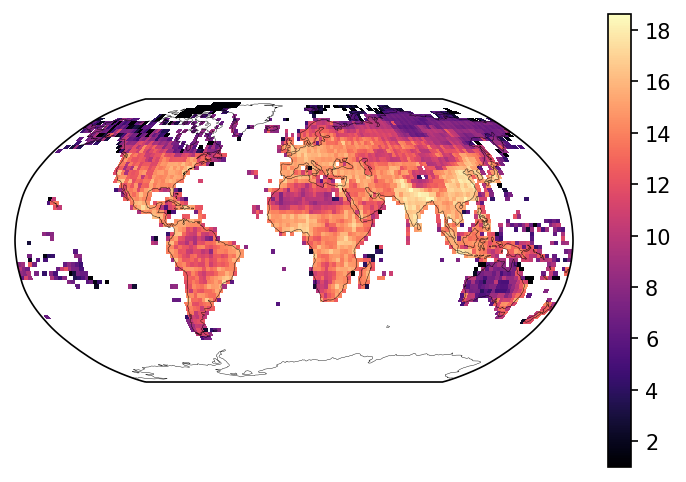

In [63]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection=ccrs.Robinson())
ax.coastlines(lw=0.2)

# We will open some population data
rds = rioxarray.open_rasterio("data/gpw_v4_population_count_rev11_2020_1_deg.asc")
rds = rds.squeeze().drop("spatial_ref").drop("band")
rds.name = "population"
pop_df = rds.to_dataframe().reset_index()

# We can round the grid points up to the grid cell size we have
pop_df['LAT'] = pop_df['y']//2.5*2.5+1.25
pop_df['LON'] = pop_df['x']//2.5*2.5+1.25
pop_df.loc[pop_df['population'].isin([-9999,0]),"population"]=np.NaN
# And take the sum of each of these larger grid cells
pop_df = pop_df.groupby(["LAT","LON"])['population'].sum().reset_index()

pop_grid_df = grid_df.merge(pop_df, how="left")
shape = (len(grid_df.LAT.unique()), len(grid_df.LON.unique()))
n = np.log(np.array(pop_grid_df.population)).reshape(shape)

mesh=ax.pcolormesh(
    grid_df.LON.unique(), 
    grid_df.LAT.unique(), 
    n, 
    cmap=plt.cm.get_cmap('magma'),
    vmin=1,
    transform=ccrs.PlateCarree(),
)

cbar = plt.colorbar(mesh)